# Task 04 - Signature Verification
Authors: Moro Palma Loris, Vedasri Nakka, Mirko Bristle, Alexandra Kovacs, Michael Brunner

Deadline: May 30, 2021
## Task
Compute dissimilarity for each verification signature with the 5 genuine ones
### Evaluation
Mean average-precision

In [3]:
import os
import glob
import pandas as pd
import numpy as np

# extract data from the txt files
path = '../SignatureVerification'
os.chdir(path)

file1names = [i for i in sorted(glob.glob('enrollment/*.txt'))]
file2names = [i for i in sorted(glob.glob('verification/*.txt'))]

enrol = [pd.read_csv(file, sep=" ", header=None, ) for file in file1names]  # 3d-array [#file][column][row]
verif = [pd.read_csv(file, sep=" ", header=None, ) for file in file2names]

In [4]:
from features import features

enrol_features = [features(enrol[i]) for i in range(5*30)]
verif_features = [features(verif[i]) for i in range(45*30)]

In [5]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def  top_verification_signs(sign_index, user_index):
    """
    compute dissimilarities with the DTW
    :param sign_index: takes value [0,5) for 5 signatures for a given user
    :param user_index: takes a value in [0, 30) for the 30 users
    :return sort: array of signature indexes sorted from smallest DTW distance to the largest
    """

    d= []
    for j in range(45):
        dist, _ = fastdtw(enrol_features[sign_index + user_index * 5],
                          verif_features[j + user_index * 45], dist = euclidean)
        d.append(dist)

    sort = np.argsort(d)
    return sort

def compute_tp(pred, ground_truth, user_index):
    """
    compute the number of true positive
    :param ground_truth: gt file
    :param pred: indexes signature prediction
    :param user_index: takes a value in [0, 30) for the 30 users
    :return counter: number of hits
    """
    counter = 0
    for index in pred:
        if ground_truth.loc[index + user_index * 45]['true'] == 'g':
            counter += 1
    return counter

Mean average precision : 0.9003872656027994


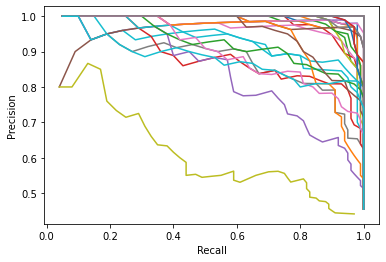

In [6]:
def compute_mean_ap(num_users):
    predictions = []
    mean_ap = 0
    gt = pd.read_csv('gt.txt', delimiter=' ', header=None, names=['id','true'])

    # compute all the dissimilarities
    for user in range(num_users):
        for signature in range(5):
            predictions.append(top_verification_signs(signature, user))

    # compute ap for each user
    for user in range(num_users):
        recalls, precisions = [], []
        ap = 0
        for k in range(1,45):   # threshold rank k
            tp, fn, fp = 0, 0, 0
            for signature_index in range(5):
                acc = compute_tp(predictions[user * 5 + signature_index][:k], gt, user)
                tp += acc
                fn += 20 - acc
                fp += k - acc

            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            recalls.append(recall)
            precisions.append(precision)
            if k!=1:
                ap += (recalls[k-1]-recalls[k-2])*precisions[k-1]

        mean_ap += ap
        plt.plot(recalls, precisions)

    print('Mean average precision :', mean_ap/num_users)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.show()

compute_mean_ap(30)